# Historical Volatility

Youtube: https://www.youtube.com/watch?v=_2wa9ldwi5A

Github: 
Methodology: 
https://www.kaggle.com/code/jiashenliu/introduction-to-financial-concepts-and-data/notebook
https://www.kaggle.com/c/optiver-realized-volatility-prediction/overview
https://www.m-x.ca/f_publications_en/cone_vol_en.pdf
https://quantpy.com.au/black-scholes-model/historical-volatility-cones/

In [3]:
import datetime as dt
import pandas as pd
import numpy as np
import calendar

from pandas_datareader import data as pdr
import matplotlib.pyplot as plt

import yfinance as yf

In [5]:
# get the historical data with pandas_datareader
yf.pdr_override()

end = dt.datetime.now()
start = dt.datetime(2000,1,1)

df = pdr.get_data_yahoo(['^AXJO'], start, end)
Close = df.Close
Close.head()

[*********************100%%**********************]  1 of 1 completed


Date
2000-01-04    3093.699951
2000-01-05    3018.699951
2000-01-06    2999.300049
2000-01-07    3023.399902
2000-01-10    3084.000000
Name: Close, dtype: float64

<AxesSubplot:xlabel='Date'>

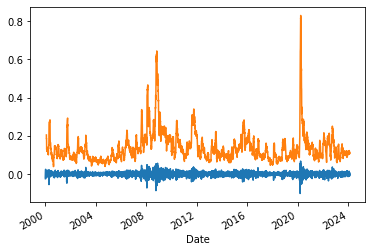

In [6]:
# compute the log returns and historical trailing volatility over a given Trading Window
log_returns = np.log(df.Close/df.Close.shift(1)).dropna()
log_returns.plot()

TRADING_DAYS = 20
volatility = log_returns.rolling(window=TRADING_DAYS).std()*np.sqrt(252)
volatility.plot()

# Creating Historical Volatility Cones
#We need to collect the third thursday of each month, as an indication the end of the monthly periods we are interested in. This is when asx options usually expire. We then need to calculate the volatility over 1, 3, 6, 9 and 12 month trading windows.

In [15]:
def ThirdThurs(year, month):
    # Create a datetime.date for the last day of the given month
    daysInMonth = calendar.monthrange(year, month)[1]   # Returns (month, numberOfDaysInMonth)
    date = dt.date(year, month, daysInMonth)
    # Back up to the most recent Thursday
    offset = 4 - date.isoweekday()
    if offset > 0: offset -= 7                          # Back up one week if necessary
    date += dt.timedelta(offset)                    # dt is now date of last Th in month
    
    # Throw an exception if dt is in the current month and occurred before today
    now = dt.date.today()                         # Get current date (local time, not utc)
    if date.year == now.year and date.month == now.month and date < now:
        raise Exception('Missed third thursday')

    return date - dt.timedelta(7)

dates = [ThirdThurs(year, month) for year in range(2000,2022) for month in range(1,13) if ThirdThurs(year, month) < dt.datetime.now().date()]
columnsNames = ['1-mth','3-mth', '6-mth', '9-mth', '12-mth']
tradingDays = [int(20*n) for n in [1,3,6,9,12]]
DTE = [int(30*n) for n in [1,3,6,9,12]]
data = np.array([np.arange(len(dates))]*len(columnsNames)).T

tradingDays
volatility = {}
for TRADING_DAYS, TimePeriod in zip(tradingDays, columnsNames):
    print(TRADING_DAYS, TimePeriod)
    volatility[TimePeriod] = log_returns.rolling(window=TRADING_DAYS).std()*np.sqrt(252)

20 1-mth
60 3-mth
120 6-mth
180 9-mth
240 12-mth


In [16]:
# historical cone dataframe
df = pd.DataFrame(data, columns=columnsNames, index=dates)
df.index.name = 'period'

def historical_vol(x):
    df2 = x.copy()
    for date, val in x.iteritems():
        try:
            df2.loc[date] = round(volatility[x.name].loc[date,'^AXJO']*100,2)
        except:
            df2.loc[date] = np.nan
    return df2
df = df.apply(lambda x: historical_vol(x),axis=0)

AttributeError: 'Series' object has no attribute 'iteritems'

In [8]:
# extract the important information, min, mean and max values. Thereby developing a distribution of historical volatility levels and we can plot this using matplotlib

In [9]:
# Plotting basic cone with matplotlib.


## Adding Implied Volatility